In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
from lmfit import Model,Parameter,Parameters
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
import os
from functions import plot_preprocessed_dist,plot_track_characteristics,mmsd_plot,cutoff_function,msd
from scipy.stats import ks_2samp

%matplotlib inline
%reload_ext autoreload

In [7]:
def compute_alphaD(files,minframe,rsquared_threshold):
    
    dt = 0.05
    maxframe = 100
    
    minalpha = 1.0E-03
    minD = 1.0E-04
    maxD = 4
    maxalpha = 3

    msd_model = Model(msd)
    params = Parameters()
    params['alpha']   = Parameter(name='alpha', value=1.0, min=minalpha,max=maxalpha)
    params['D']   = Parameter(name='D', value=0.1, min=minD,max=maxD)
    
    frame_alldata = []
    alphaD = []
    rhoens_alltracks = []
    reduced_linear_data = []
    INDEX = []

    total_tracks=0
    anomalous_percentage=0

    for filename in files:
        folder_name = filename[5:-4]
        output_folder = "Result/"+folder_name

        data = pd.read_csv(filename) 
        tracklist = data.TRACK_ID.unique()  #list of track ID in data

        for tid in tracklist:

            trackid = data["TRACK_ID"] == tid
            x = data[trackid]["POSITION_X"].to_numpy()   #x associated to track 'tid'
            y = data[trackid]["POSITION_Y"].to_numpy()   #y associated to track 'tid'
            intensity = data[trackid]["MEAN_INTENSITY"].to_numpy()

            frame_alldata.append(len(x))

            rhon = []#list of rho_n for a given track
            if len(x)<maxframe and len(x)>minframe:
                for n in range(1,len(x)):             #for each n = each time lag
                    s = 0
                    for i in range(0,len(x)-n):
                        s+=(x[n+i] - x[i])**2 + (y[n+i] - y[i])**2
                    rhon.append(1/(len(x)-n)*s)

                N = len(rhon)+1
                t = [n*dt for n in np.linspace(1,N-1,N-1)]

                nbrpts = int(0.3*N)
                result = msd_model.fit(rhon[:nbrpts+1], params, t=t[:nbrpts+1])

                s=0
                for p in range(0,len(x)-1):
                    s+= np.sqrt((x[p+1]-x[p])**2+(y[p+1]-y[p])**2)
                confinement_ratio = np.sqrt((x[-1]-x[0])**2+(y[-1]-y[0])**2)/s

                alpha = result.params['alpha'].value
                D = result.params['D'].value
                rsquare = 1 - result.residual.var() / np.var(rhon[:nbrpts+1])

                if rsquare > rsquared_threshold and confinement_ratio!=0.0:
                    rhoens_alltracks.append(rhon)
                    plot_element = [alpha,D,confinement_ratio,len(x)] #len(x)
                    alphaD.append(plot_element)
                    INDEX.append([x,y])

                else:
                    anomalous_percentage+=1
                total_tracks+=1
    return(alphaD)


import random 
def partition(list_in, n):
    random.shuffle(list_in)
    return([list_in[i::n] for i in range(n)])

print(np.linspace(0.4,0.95,12))

[0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]


Process LP184 data with MinFrame =  8.0  and R² threshold =  0.4
Process LP184_VBS199_sup data with MinFrame =  8.0  and R² threshold =  0.4
Global Stat =  0.07170825390401744  pvalue =  1.0


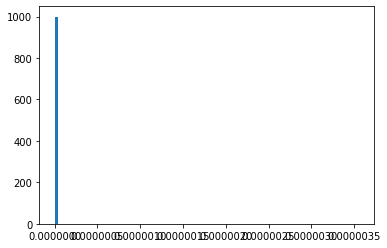

Average pvalue =  0.0 Average stat number =  0.998
Control on LP14 :  99.827 0.0
Control on LP14_VBS :  99.943 0.0
Process LP184 data with MinFrame =  8.0  and R² threshold =  0.45


KeyboardInterrupt: 

In [94]:
dt = 0.05  #time step
maxframe = 100
minframe_array = np.linspace(5,20,21)
rsquared_array = np.linspace(0.4,0.95,12)

minalpha = 1.0E-03
minD = 1.0E-04
maxD = 4
maxalpha = 3

msd_model = Model(msd)
params = Parameters()
params['alpha']   = Parameter(name='alpha', value=1.0, min=minalpha,max=maxalpha)
params['D']   = Parameter(name='D', value=0.1, min=minD,max=maxD)

matrix_pvalue = np.zeros((len(minframe_array),len(rsquared_array)))
matrix_stat = np.zeros((len(minframe_array),len(rsquared_array)))
matrix_LP184_pvalue = np.zeros((len(minframe_array),len(rsquared_array)))
matrix_LP184_stat = np.zeros((len(minframe_array),len(rsquared_array)))
matrix_LP184_VBS_pvalue = np.zeros((len(minframe_array),len(rsquared_array)))
matrix_LP184_VBS_stat   = np.zeros((len(minframe_array),len(rsquared_array)))

for i in range(np.shape(matrix_pvalue)[0]):
    for j in range(np.shape(matrix_pvalue)[1]):
        
        minframe = minframe_array[i]
        rsquared_threshold = rsquared_array[j]
        
        #files = ["Data/SM1/sm1_ld200.csv","Data/SM2/sm2_ld200.csv","Data/SM3/sm3_ld200.csv","Data/SM4/sm4_ld200.csv","Data/SM5/sm5_ld200.csv","Data/SM6/sm6_ld200.csv","Data/SM7/sm7_ld200.csv","Data/SM8/sm8_ld200.csv","Data/SM9/sm9_ld200.csv","Data/SM10/sm10_ld200.csv"]
        files = ["Data/SM1/sm1_ld400.csv","Data/SM2/sm2_ld400.csv","Data/SM3/sm3_ld400.csv","Data/SM4/sm4_ld400.csv","Data/SM5/sm5_ld400.csv","Data/SM6/sm6_ld400.csv","Data/SM7/sm7_ld400.csv","Data/SM8/sm8_ld400.csv","Data/SM9/sm9_ld400.csv","Data/SM10/sm10_ld400.csv"]
        print("Process LP184 data with MinFrame = ",minframe," and R² threshold = ",rsquared_threshold)
        all_data1 = np.array(compute_alphaD(files,minframe,rsquared_threshold))
        
        #files_wnt = ["Data/SM1_WNT/sm1_wnt_ld200.csv","Data/SM2_WNT/sm2_wnt_ld200.csv","Data/SM3_WNT/sm3_wnt_ld200.csv","Data/SM4_WNT/sm4_wnt_ld200.csv","Data/SM5_WNT/sm5_wnt_ld200.csv","Data/SM6_WNT/sm6_wnt_ld200.csv","Data/SM7_WNT/sm7_wnt_ld200.csv","Data/SM8_WNT/sm8_wnt_ld200.csv","Data/SM10_WNT/sm10_wnt_ld200.csv"]
        files_wnt = ["Data/SM1_WNT/sm1_wnt_ld400.csv","Data/SM2_WNT/sm2_wnt_ld400.csv","Data/SM3_WNT/sm3_wnt_ld400.csv","Data/SM4_WNT/sm4_wnt_ld400.csv","Data/SM5_WNT/sm5_wnt_ld400.csv","Data/SM6_WNT/sm6_wnt_ld400.csv","Data/SM7_WNT/sm7_wnt_ld400.csv","Data/SM8_WNT/sm8_wnt_ld400.csv","Data/SM10_WNT/sm10_wnt_ld400.csv"]
        print("Process LP184_VBS199_sup data with MinFrame = ",minframe," and R² threshold = ",rsquared_threshold)
        all_data2 = np.array(compute_alphaD(files_wnt,minframe,rsquared_threshold))
        
        DATA = all_data1
        DATA_WNT = all_data2

        darray = DATA[:,1]
        darray_wnt = DATA_WNT[:,1]
        stat, pvalue = ks_2samp(darray,darray_wnt)
        print("Global Stat = ",stat," pvalue = ",pvalue)
        
        bootstrap = []
        nloop = 1000
        s1 = 0
        s2 = 0
        s3 = 0
        s4 = 0
        s5 = 0
        s6 = 0
        for k in range(nloop):
            # 2-SAMPLE TEST
            length = [np.shape(all_data1)[0],np.shape(all_data2)[0]]
            batch_size = int(min(length)/4)
            temp1 = partition(all_data1,1)[0]
            temp2 = partition(all_data2,1)[0]
            
            DATA = temp1[:batch_size][:]
            DATA_WNT = temp2[:batch_size][:]

            darray = DATA[:,1]
            darray_wnt = DATA_WNT[:,1]
            stat, pvalue = ks_2samp(darray,darray_wnt)
            
            s1 += stat
            s2 += pvalue
            bootstrap.append(pvalue)
            
            #1st SAMPLE TEST CONTROL
            temp_LP184 = partition(all_data1, 4)
            DATA1_LP184 = temp_LP184[0]
            DATA2_LP184 = temp_LP184[1]

            darray1_LP184 = DATA1_LP184[:,1]
            darray2_LP184 = DATA2_LP184[:,1]
            stat_LP184, pvalue_LP184 = ks_2samp(darray1_LP184,darray2_LP184)
            
            s3 += stat_LP184
            s4 += pvalue_LP184
            
            #2nd SAMPLE TEST CONTROL
            temp_LP184_VBS = partition(all_data2, 4)
            DATA1_LP184_VBS = temp_LP184_VBS[0]
            DATA2_LP184_VBS = temp_LP184_VBS[1]

            darray1_LP184_VBS = DATA1_LP184_VBS[:,1]
            darray2_LP184_VBS = DATA2_LP184_VBS[:,1]
            stat_LP184_VBS, pvalue_LP184_VBS = ks_2samp(darray1_LP184_VBS,darray2_LP184_VBS)
            
            s5 += stat_LP184_VBS
            s6 += pvalue_LP184_VBS
        
        plt.hist(bootstrap,bins=100)
        plt.show()
        
        pvalue_average = round(100*s2/nloop,3)
        stat_average   = round(s1/nloop,3)
        print("Average pvalue = ",pvalue_average,"Average stat number = ",stat_average)

        pvalue_average_LP184 = round(100*s4/nloop,3)
        stat_average_LP184   = round(s3/nloop,3)
        print("Control on LP14 : ",pvalue_average_LP184, stat_average_LP184)

        pvalue_average_LP184_VBS = round(100*s6/nloop,3)
        stat_average_LP184_VBS   = round(s5/nloop,3)
        print("Control on LP14_VBS : ",pvalue_average_LP184_VBS, stat_average_LP184_VBS)
        
        
        matrix_pvalue[i][j] = pvalue_average
        matrix_stat[i][j] = stat_average
        matrix_LP184_pvalue[i][j] = pvalue_average_LP184
        matrix_LP184_stat[i][j] = stat_average_LP184
        matrix_LP184_VBS_pvalue[i][j] = pvalue_average_LP184_VBS
        matrix_LP184_VBS_stat[i][j] = stat_average_LP184_VBS
        
np.savetxt("pvalue_ld400.txt",matrix_pvalue)
np.savetxt("stat_ld400.txt",matrix_stat)
np.savetxt("pvalue_ld400_lp184.txt",matrix_LP184_pvalue)
np.savetxt("stat_l400_lp184.txt",matrix_LP184_stat)
np.savetxt("pvalue_ld400_lp184vbs.txt",matrix_LP184_VBS_pvalue)
np.savetxt("stat_l400_lp184vbs.txt",matrix_LP184_VBS_stat)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


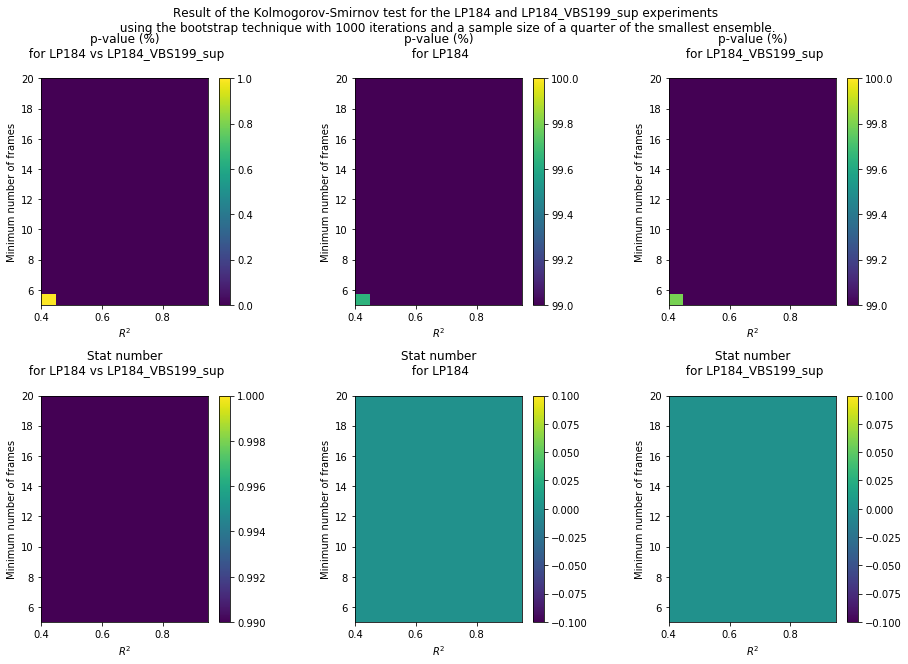

In [87]:
import matplotlib as mpl
np.savetxt('Minframe.txt',minframe_array)
np.savetxt('R2.txt',rsquared_array)

fig = plt.figure(figsize=(15, 10))
grid = plt.GridSpec(2, 3, hspace=0.4, wspace=0.5)
pvalue = fig.add_subplot(grid[0,0])
stat = fig.add_subplot(grid[1,0])
pvalue_LP184  = fig.add_subplot(grid[0,1])
stat_LP184 = fig.add_subplot(grid[1,1])
pvalue_LP184_VBS = fig.add_subplot(grid[0,2])
stat_LP184_VBS = fig.add_subplot(grid[1,2])


mesh = pvalue.pcolor(rsquared_array,minframe_array,matrix_pvalue)
pvalue.set_xlabel(r'$R^2$')
pvalue.set_ylabel('Minimum number of frames')
pvalue.set_title('p-value (%)\n for LP184 vs LP184_VBS199_sup\n')
mesh.set_clim(0,1)
fig.colorbar(mesh,ax=pvalue)

mesh2 = pvalue_LP184.pcolor(rsquared_array,minframe_array,matrix_LP184_pvalue)
pvalue_LP184.set_xlabel(r'$R^2$')
pvalue_LP184.set_ylabel('Minimum number of frames')
pvalue_LP184.set_title('p-value (%)\n for LP184\n')
mesh2.set_clim(99,100)
fig.colorbar(mesh2,ax=pvalue_LP184)


mesh3 = pvalue_LP184_VBS.pcolor(rsquared_array,minframe_array,matrix_LP184_VBS_pvalue)
pvalue_LP184_VBS.set_xlabel(r'$R^2$')
pvalue_LP184_VBS.set_ylabel('Minimum number of frames')
pvalue_LP184_VBS.set_title('p-value (%)\n for LP184_VBS199_sup\n')
mesh3.set_clim(99,100)
fig.colorbar(mesh3,ax=pvalue_LP184_VBS)


mesh4 = stat.pcolormesh(rsquared_array,minframe_array,matrix_stat)
stat.set_xlabel(r'$R^2$')
stat.set_ylabel('Minimum number of frames')
stat.set_title('Stat number\n for LP184 vs LP184_VBS199_sup\n')
mesh4.set_clim(0.99,1.0)
fig.colorbar(mesh4,ax=stat)


mesh5 = stat_LP184.pcolormesh(rsquared_array,minframe_array,matrix_LP184_stat)
stat_LP184.set_xlabel(r'$R^2$')
stat_LP184.set_ylabel('Minimum number of frames')
stat_LP184.set_title('Stat number\n for LP184\n')

fig.colorbar(mesh5,ax=stat_LP184)



mesh6 = stat_LP184_VBS.pcolormesh(rsquared_array,minframe_array,matrix_LP184_VBS_stat)
stat_LP184_VBS.set_xlabel(r'$R^2$')
stat_LP184_VBS.set_ylabel('Minimum number of frames')
stat_LP184_VBS.set_title('Stat number\n for LP184_VBS199_sup\n')
fig.colorbar(mesh6,ax=stat_LP184_VBS)

plt.suptitle('Result of the Kolmogorov-Smirnov test for the LP184 and LP184_VBS199_sup experiments\n using the bootstrap technique with '+str(nloop)+' iterations and a sample size of a quarter of the smallest ensemble.\n')
plt.tight_layout()
plt.savefig('KStestMLD400.png')

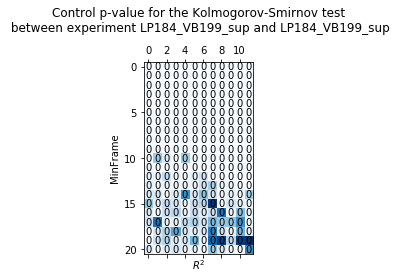

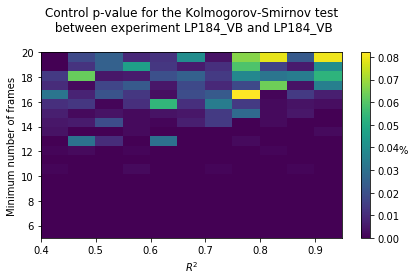

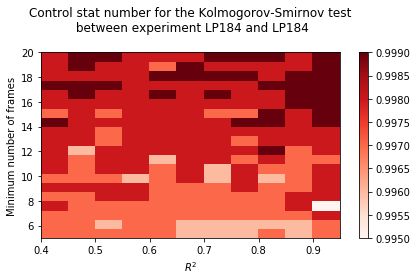

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.001 0.    0.    0.002 0.    0.    0.001 0.    0.    0.001 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.001 0.002 0.    0.001 0.    0.    0.    0.    0.001 0.    0.    0.   ]
 [0.    0.031 0.01  0.    0.03  0.    0.    0.002 0.    0.    0.    0.   ]
 [0.004 0.    0.    0.002 0.    0.    0.    0.    0.    0.    0.002 0.   ]
 [0.005 0.006 0.019 0.002 0.001 0.007 0.014 0.    0.002 0.    0.    0.   ]
 [0.007 0.002 0.004 0.002

In [9]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
min_val, max_val = 0, 100
ax.matshow(matrix_pvalue, cmap=plt.cm.Blues)
ax.set_xlabel(r'$R^2$')
ax.set_ylabel('MinFrame')

for i in range(np.shape(matrix_pvalue)[1]):
    for j in range(np.shape(matrix_pvalue)[0]):
        c = matrix_pvalue[j,i]
        ax.text(i,j, str(int(c)), va='center', ha='center')
        
plt.title('Control p-value for the Kolmogorov-Smirnov test\n between experiment LP184_VB199_sup and LP184_VB199_sup\n')
plt.tight_layout()
plt.savefig('pvalue_ld200.png')
plt.show()

plt.pcolormesh(rsquared_array,minframe_array,matrix_pvalue,cmap="viridis")
cbar = plt.colorbar()
cbar.set_label('%', rotation=0)
plt.xlabel(r'$R^2$')
plt.ylabel('Minimum number of frames')
plt.title('Control p-value for the Kolmogorov-Smirnov test\n between experiment LP184_VB and LP184_VB\n')
plt.tight_layout()
plt.show()

#plt.imshow(matrix_stat,cmap="Reds")
plt.pcolormesh(rsquared_array,minframe_array,matrix_stat,cmap="Reds")
#plt.xticks(rsquared_array)
#plt.yticks(minframe_array)
plt.xlabel(r'$R^2$')
plt.ylabel('Minimum number of frames')
plt.colorbar()
plt.title('Control stat number for the Kolmogorov-Smirnov test\n between experiment LP184 and LP184\n')
plt.tight_layout()
#plt.savefig('stat_ld400.png')
plt.show()

np.savetxt("pvalue_ld200.txt",matrix_pvalue)
np.savetxt("stat_ld200.txt",matrix_stat)

print(matrix_pvalue)

In [103]:
dt = 0.05  #time step
maxframe = 100
minframe_array = np.linspace(5,12,8)
rsquared_array = np.linspace(0.4,0.95,5)

minalpha = 1.0E-03
minD = 1.0E-04
maxD = 4
maxalpha = 3

msd_model = Model(msd)
params = Parameters()
params['alpha']   = Parameter(name='alpha', value=1.0, min=minalpha,max=maxalpha)
params['D']   = Parameter(name='D', value=0.1, min=minD,max=maxD)

matrix_pvalue = np.zeros((len(minframe_array),len(rsquared_array)))
matrix_stat = np.zeros((len(minframe_array),len(rsquared_array)))


for i in range(np.shape(matrix_pvalue)[0]):
    for j in range(np.shape(matrix_pvalue)[1]):
        
        minframe = minframe_array[i]
        rsquared_threshold = rsquared_array[j]
        
        #files = ["Data/SM1/sm1_ld400.csv","Data/SM2/sm2_ld400.csv","Data/SM3/sm3_ld400.csv","Data/SM4/sm4_ld400.csv","Data/SM5/sm5_ld400.csv","Data/SM6/sm6_ld400.csv","Data/SM7/sm7_ld400.csv","Data/SM8/sm8_ld400.csv","Data/SM9/sm9_ld400.csv","Data/SM10/sm10_ld400.csv"]
        files = ["Data/SM1_WNT/sm1_wnt_ld400.csv","Data/SM2_WNT/sm2_wnt_ld400.csv","Data/SM3_WNT/sm3_wnt_ld400.csv","Data/SM4_WNT/sm4_wnt_ld400.csv","Data/SM5_WNT/sm5_wnt_ld400.csv","Data/SM6_WNT/sm6_wnt_ld400.csv","Data/SM7_WNT/sm7_wnt_ld400.csv","Data/SM8_WNT/sm8_wnt_ld400.csv","Data/SM10_WNT/sm10_wnt_ld400.csv"]
        print("Process LP184 data with MinFrame = ",minframe," and R² threshold = ",rsquared_threshold)
        all_data = np.array(compute_alphaD(files,minframe,rsquared_threshold))
        print("Done. Perform K-S test.")
        
        nloop = 500
        s1 = 0
        s2 = 0
        for k in range(nloop):
            temp = partition(all_data, 2)
            DATA1 = temp[0]
            DATA2 = temp[1]

            darray1 = DATA1[:,1]
            darray2 = DATA2[:,1]
            stat, pvalue = ks_2samp(darray1,darray2)
            
            s1 += stat
            s2 += pvalue
            
        pvalue_average = round(100*s2/nloop,3)
        stat_average   = round(s1/nloop,3)
        print(pvalue_average, stat_average)
        
        matrix_pvalue[i][j] = pvalue_average
        matrix_stat[i][j] = stat_average

Process LP184 data with MinFrame =  5.0  and R² threshold =  0.4
Done. Perform K-S test.
99.106 0.0
Process LP184 data with MinFrame =  5.0  and R² threshold =  0.5375
Done. Perform K-S test.
100.0 0.0
Process LP184 data with MinFrame =  5.0  and R² threshold =  0.675
Done. Perform K-S test.
100.0 0.0
Process LP184 data with MinFrame =  5.0  and R² threshold =  0.8125
Done. Perform K-S test.
99.066 0.0
Process LP184 data with MinFrame =  5.0  and R² threshold =  0.95
Done. Perform K-S test.
99.25 0.0
Process LP184 data with MinFrame =  6.0  and R² threshold =  0.4
Done. Perform K-S test.
100.0 0.001
Process LP184 data with MinFrame =  6.0  and R² threshold =  0.5375
Done. Perform K-S test.
99.602 0.0
Process LP184 data with MinFrame =  6.0  and R² threshold =  0.675
Done. Perform K-S test.
99.137 0.001
Process LP184 data with MinFrame =  6.0  and R² threshold =  0.8125
Done. Perform K-S test.
99.189 0.001
Process LP184 data with MinFrame =  6.0  and R² threshold =  0.95
Done. Perform K

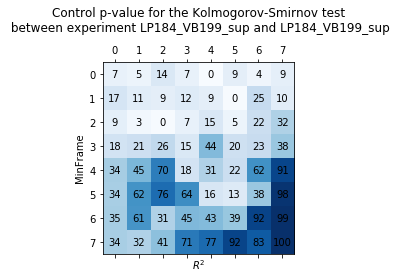

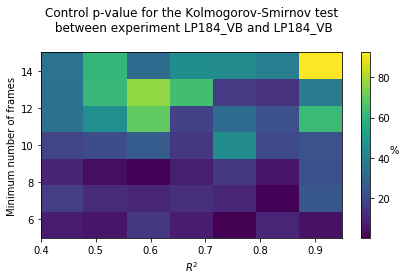

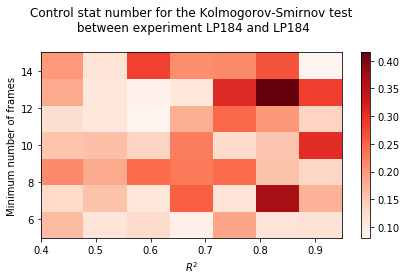

[[  7.513   5.6    14.888   7.731   0.236   9.809   4.295   9.007]
 [ 17.033  11.064   9.969  12.602   9.716   0.903  25.152  10.564]
 [  9.365   3.166   0.682   7.995  15.182   5.611  22.782  32.564]
 [ 18.843  21.488  26.689  15.014  44.516  20.867  23.71   38.674]
 [ 34.922  45.876  70.026  18.376  31.906  22.663  62.671  91.606]
 [ 34.463  62.038  76.955  64.516  16.12   13.198  38.549  98.148]
 [ 35.156  61.231  31.972  45.178  43.994  39.12   92.353  99.945]
 [ 34.387  32.184  41.663  71.791  77.657  92.149  83.538 100.   ]]


In [119]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
min_val, max_val = 0, 100
ax.matshow(matrix_pvalue, cmap=plt.cm.Blues)
ax.set_xlabel(r'$R^2$')
ax.set_ylabel('MinFrame')

for i in range(np.shape(matrix_pvalue)[1]):
    for j in range(np.shape(matrix_pvalue)[0]):
        c = matrix_pvalue[j,i]
        ax.text(i,j, str(int(c)), va='center', ha='center')
        
plt.title('Control p-value for the Kolmogorov-Smirnov test\n between experiment LP184_VB199_sup and LP184_VB199_sup\n')
plt.tight_layout()
plt.savefig('pvalue_ld400.png')
plt.show()

plt.pcolormesh(rsquared_array,minframe_array,matrix_pvalue,cmap="viridis")
cbar = plt.colorbar()
cbar.set_label('%', rotation=0)
plt.xlabel(r'$R^2$')
plt.ylabel('Minimum number of frames')
plt.title('Control p-value for the Kolmogorov-Smirnov test\n between experiment LP184_VB and LP184_VB\n')
plt.tight_layout()
plt.show()

#plt.imshow(matrix_stat,cmap="Reds")
plt.pcolormesh(rsquared_array,minframe_array,matrix_stat,cmap="Reds")
#plt.xticks(rsquared_array)
#plt.yticks(minframe_array)
plt.xlabel(r'$R^2$')
plt.ylabel('Minimum number of frames')
plt.colorbar()
plt.title('Control stat number for the Kolmogorov-Smirnov test\n between experiment LP184 and LP184\n')
plt.tight_layout()
#plt.savefig('stat_ld400.png')
plt.show()

np.savetxt("pvalue_LP184_VB_control.txt",matrix_pvalue)
np.savetxt("stat_LP184_VB_control.txt",matrix_stat)

print(matrix_pvalue)